In [6]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Linear Model
from statsmodels.formula.api import ols


from sklearn.metrics import mean_squared_error
from math import sqrt

from pydataset import data

In [11]:
#Read in the dataset
import pandas as pd
import os
from env import username, password, host

def get_db_url(database):
    return f'mysql+pymysql://{username}:{password}@{host}/{database}'

"""
USAGE: 
Use `from wrangle import wrangle_zillow` at the top of your notebook.
This 
"""
def get_zillow_data():
    """Seeks to read the cached zillow.csv first """
    filename = "zillow.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        return get_new_zillow_data()

def get_new_zillow_data():
    """Returns a dataframe of all 2017 properties that are Single Family Residential"""

    sql = """
    select 
    bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    from properties_2017
    join propertylandusetype using (propertylandusetypeid)
    where propertylandusedesc = "Single Family Residential"
    """
    return pd.read_sql(sql, get_db_url("zillow"))


def handle_nulls(df):    
    # We keep 99.41% of the data after dropping nulls
    # round(df.dropna().shape[0] / df.shape[0], 4) returned .9941
    df = df.dropna()
    return df


def optimize_types(df):
    # Convert some columns to integers
    # fips, yearbuilt, and bedrooms can be integers
    df["fips"] = df["fips"].astype(int)
    df["yearbuilt"] = df["yearbuilt"].astype(int)
    df["bedroomcnt"] = df["bedroomcnt"].astype(int)    
    df["taxvaluedollarcnt"] = df["taxvaluedollarcnt"].astype(int)
    df["calculatedfinishedsquarefeet"] = df["calculatedfinishedsquarefeet"].astype(int)
    return df


def handle_outliers(df):
    """Manually handle outliers that do not represent properties likely for 99% of buyers and zillow visitors"""
    df = df[df.bathroomcnt <= 6]
    
    df = df[df.bedroomcnt <= 6]
    
    df = df[df.calculatedfinishedsquarefeet < 8000]
    
    df = df[df.taxvaluedollarcnt < 1000000]

    return df


def wrangle_zillow():
    """
    Acquires Zillow data
    Handles nulls
    optimizes or fixes data types
    handles outliers w/ manual logic
    returns a clean dataframe
    """
    df = get_zillow_data()

    df = handle_nulls(df)

    df = optimize_types(df)

    df = handle_outliers(df)

    df.to_csv("zillow.csv", index=False)

    return df


In [10]:
#Find all of the "Single Family Residential" properties from 2017.
sql = """
select 
bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
from properties_2017
join propertylandusetype using (propertylandusetypeid)
where propertylandusedesc = "Single Family Residential"
"""

df = pd.read_sql(sql, get_db_url("zillow"))
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [12]:
# splitting the data into train, validate, and test
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
print(train.shape, validate.shape, test.shape)

(1205603, 7) (516687, 7) (430573, 7)


In [13]:
# let's generate an average baseline prediction

baseline_predictions = round(train["taxvaluedollarcnt"].mean(), 2)
baseline_predictions

461960.14

#### Takeaways
- Baseline prediction mean is the predicted house value average of all records in the Zillow train dataset
- Is this the correct average to assume for the dataset

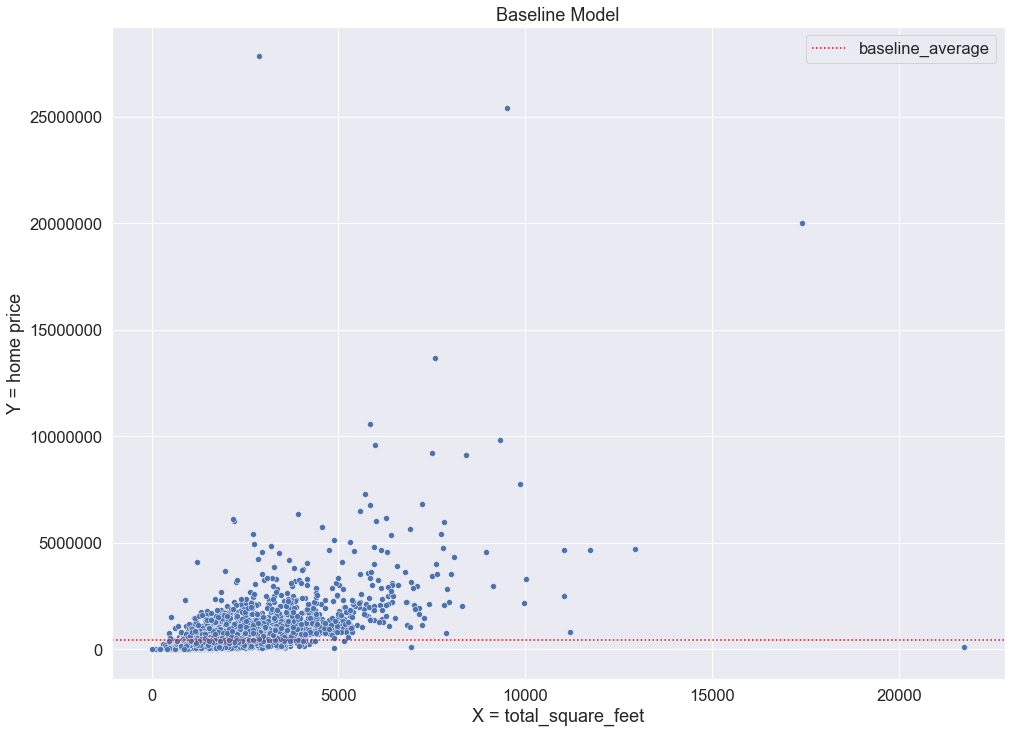

In [14]:
# Time to plot the mean baseline prediction against actual targets

plt.figure(figsize = (16,12))
sns.set(font_scale = 1.5)

sns.scatterplot(x = "calculatedfinishedsquarefeet", y = "taxvaluedollarcnt", data = train.sample(10000), x_jitter = 0.5)
plt.ticklabel_format(style = "plain") 

plt.axhline(baseline_predictions, ls = ':', color = "red", label = "baseline_average")
plt.xlabel('X = total_square_feet')
plt.ylabel('Y = home price')

plt.legend()
plt.title('Baseline Model')
plt.show()

In [15]:
from sklearn.linear_model import LinearRegression

# creating the independent and dependent variables
X_var = pd.DataFrame(train.calculatedfinishedsquarefeet)
y_var = pd.DataFrame(train.taxvaluedollarcnt)

In [16]:
# creating the model

model = LinearRegression(normalize = True)
model.fit(X_var, y_var)
predictions = model.predict(X_var)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# let's create a dataframe with all four features:
# home_value (dependent variable)
# finished_sq_feet (independent variable)
# predicted avg. baseline home value
# created model predictions

df = pd.concat([X_var, y_var], axis = 1)
df["baseline"] = baseline_predictions